In [2]:
!pip install sumy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 70.2 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=796b71480651eb5469c0014f4fe874674b6069c0844f9c23a64ce955e57124a2
  Stored in directory: /root/.cache/pip/wheels/4d/57/58/7e3d7fedf51fe248b7fcee3df6945ae28638e22cddf01eb92b
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=5844c3bfc71fc973fe6fa0004b28532acaaed960439d09a540f49defad07f438
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built breadability docopt


In [5]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6236efaae27009722c5545e50aac618959bce37f9bb02f5bb665f6e94286e9ba
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [9]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab') # Add this line to download the missing resource

import pandas as pd
from tqdm import tqdm
from transformers import BartTokenizer, BartForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
# قراءة البيانات
df = pd.read_csv("xsum.csv")
subset = df.head(50)

In [11]:
# ========== BART ==========
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-xsum")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-xsum")
bart_summaries = []
for text in tqdm(subset["input"].tolist(), desc="BART Summaries"):
    inputs = bart_tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = bart_model.generate(inputs, max_length=60, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    bart_summaries.append(summary)
subset["bart_summary"] = bart_summaries

BART Summaries: 100%|██████████| 50/50 [06:02<00:00,  7.26s/it]
<ipython-input-11-8298e6cc338d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["bart_summary"] = bart_summaries


In [12]:
# ========== T5 ==========
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base")
t5_summaries = []
for text in tqdm(subset["input"].tolist(), desc="T5 Summaries"):
    input_text = "summarize: " + text
    inputs = t5_tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=60, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    t5_summaries.append(summary)
subset["t5_summary"] = t5_summaries


T5 Summaries: 100%|██████████| 50/50 [07:21<00:00,  8.83s/it]
<ipython-input-12-8b7c38a88fc2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["t5_summary"] = t5_summaries


In [13]:
# ========== TextRank ==========
textrank_summaries = []
for text in tqdm(subset["input"].tolist(), desc="TextRank Summaries"):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, 3)
    joined = " ".join(str(sentence) for sentence in summary)
    textrank_summaries.append(joined)
subset["textrank_summary"] = textrank_summaries

TextRank Summaries: 100%|██████████| 50/50 [00:01<00:00, 30.79it/s]
<ipython-input-13-b191a0fa2ec8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["textrank_summary"] = textrank_summaries


In [14]:
# ========== FLAN-T5 + Prompt Engineering ==========
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

flan_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
flan_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
flan_summaries = []

for text in tqdm(subset["input"].tolist(), desc="FLAN-T5 Summaries"):
    input_text = "Summarize the following in a concise and informative way:\n" + text.strip()
    inputs = flan_tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = flan_model.generate(inputs["input_ids"], max_length=60, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = flan_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    flan_summaries.append(summary)

subset["flan_summary"] = flan_summaries

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

FLAN-T5 Summaries: 100%|██████████| 50/50 [03:38<00:00,  4.37s/it]
<ipython-input-14-198487cd4704>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["flan_summary"] = flan_summaries


In [15]:
# ========== ROUGE ==========
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def compute_rouge(refs, gens):
    r1, r2, rL = [], [], []
    for ref, gen in zip(refs, gens):
        scores = scorer.score(ref, gen)
        r1.append(scores["rouge1"].fmeasure)
        r2.append(scores["rouge2"].fmeasure)
        rL.append(scores["rougeL"].fmeasure)
    return r1, r2, rL

bart_r1, bart_r2, bart_rL = compute_rouge(subset["target"], subset["bart_summary"])
t5_r1, t5_r2, t5_rL = compute_rouge(subset["target"], subset["t5_summary"])
txt_r1, txt_r2, txt_rL = compute_rouge(subset["target"], subset["textrank_summary"])
flan_r1, flan_r2, flan_rL = compute_rouge(subset["target"], subset["flan_summary"])

def print_rouge(name, r1, r2, rL):
    print(f"\n{name} ROUGE Scores")
    print(f"ROUGE-1: {sum(r1)/len(r1):.4f}")
    print(f"ROUGE-2: {sum(r2)/len(r2):.4f}")
    print(f"ROUGE-L: {sum(rL)/len(rL):.4f}")

print_rouge("BART", bart_r1, bart_r2, bart_rL)
print_rouge("T5", t5_r1, t5_r2, t5_rL)
print_rouge("TextRank", txt_r1, txt_r2, txt_rL)
print_rouge("FLAN-T5", flan_r1, flan_r2, flan_rL)



BART ROUGE Scores
ROUGE-1: 0.4821
ROUGE-2: 0.2541
ROUGE-L: 0.4075

T5 ROUGE Scores
ROUGE-1: 0.1975
ROUGE-2: 0.0366
ROUGE-L: 0.1425

TextRank ROUGE Scores
ROUGE-1: 0.1633
ROUGE-2: 0.0276
ROUGE-L: 0.1107

FLAN-T5 ROUGE Scores
ROUGE-1: 0.3754
ROUGE-2: 0.1313
ROUGE-L: 0.2880


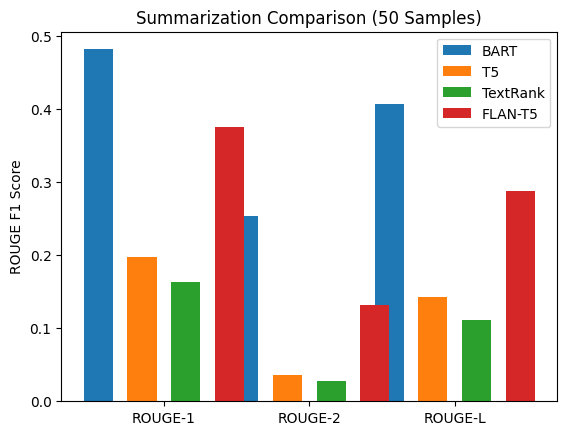

In [16]:
# ========== Visualization ==========
labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
x = range(len(labels))

plt.bar([i - 0.45 for i in x], [sum(bart_r1)/len(bart_r1), sum(bart_r2)/len(bart_r2), sum(bart_rL)/len(bart_rL)], width=0.2, label="BART")
plt.bar([i - 0.15 for i in x], [sum(t5_r1)/len(t5_r1), sum(t5_r2)/len(t5_r2), sum(t5_rL)/len(t5_rL)], width=0.2, label="T5")
plt.bar([i + 0.15 for i in x], [sum(txt_r1)/len(txt_r1), sum(txt_r2)/len(txt_r2), sum(txt_rL)/len(txt_rL)], width=0.2, label="TextRank")
plt.bar([i + 0.45 for i in x], [sum(flan_r1)/len(flan_r1), sum(flan_r2)/len(flan_r2), sum(flan_rL)/len(flan_rL)], width=0.2, label="FLAN-T5")

plt.xticks(x, labels)
plt.ylabel("ROUGE F1 Score")
plt.title("Summarization Comparison (50 Samples)")
plt.legend()
plt.show()

In [17]:
# ========== Save Results ==========
subset.to_csv("xsum_all_models_comparison.csv", index=False)
print("Saved to xsum_all_models_comparison.csv")

# ========== Show Sample Outputs ==========
for i in range(2):
    print("\n--- Example", i+1, "---")
    print("Original:", subset['input'].iloc[i])
    print("Target:", subset['target'].iloc[i])
    print("BART:", subset['bart_summary'].iloc[i])
    print("T5:", subset['t5_summary'].iloc[i])
    print("TextRank:", subset['textrank_summary'].iloc[i])
    print("FLAN-T5:", subset['flan_summary'].iloc[i])

Saved to xsum_all_models_comparison.csv

--- Example 1 ---
Original: The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian sport.
Mr Sodje, 37, is jointly charged with elder brothers Efe, 44, Bright, 50 and Stephen, 42.
Appearing at the Old Bailey earlier, all four denied the offence.
The charge relates to offences which allegedly took place between 2008 and 2014.
Sam, from Kent, Efe and Bright, of Greater Manchester, and Stephen, from Bexley, are due to stand trial in July.
They were all released on bail. A summary is
Target: Former Premier League footballer Sam Sodje has appeared in court alongside three brothers accused of charity fraud.
BART: Former Premier League footballer Sam Sodje has pleaded not guilty to fraud and money laundering charges.
T5: ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian sport . the 37-yea